# Dimensionality reduction using graphs

In [1]:
from utils import visualization, weights, features, build, embedding, dim_reduction, evaluation
from data import preprocessing, small
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.decomposition import PCA
import umap

c:\Users\david\anaconda3\envs\graphs-py3.6\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
c:\Users\david\anaconda3\envs\graphs-py3.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Graph building

At first, we illustrate our graph building algorithm on toy dataset.

In [ ]:
data = np.array([[3,-1],
                 [4,0],
                 [5,-2],
                 [4,6],
                 [5,7],
                 [5.5,6]])
labels=[0,0,0,1,1,1]
visualization.show_data(data=data, labels=labels, square=True)

We create an instance of CheapestBuilder class. This is our main algorithm for graph building. We also created other graph building algorithms shown at the end of the notebook.

The Cheapest builder computes pairwise distances between datapoints, sorts them from the shortest to longest and then adds edges from the shortest one by one until a connected graph is obtained.

Weights can be assigned as a function of distances. Here we use w=1/distance (weights.reciprocal). We also implemented w=1/(distance)^k (weights.reciprocal_pow)

In [2]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)

In [3]:
builder.build(data)
graph = builder.graph

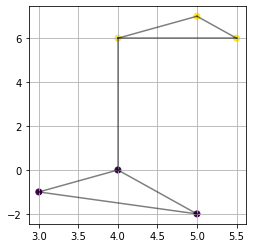

In [4]:
visualization.show_data(data=data, graph=graph, labels=labels, square=True)

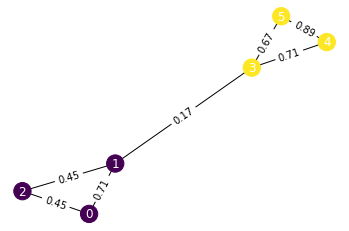

In [5]:
visualization.show_graph(graph=graph, labels=labels, dpi=600, show_numbers=True)

## Node embedding

Having a graph representing our data, we can use it to generate low-dimensional embeddings. At first, we use the graph without any node features, then we add features for using GraphSAGE.

### Without node features
Having no node features, we use only the graph itself and edge weights. For embedding, we can use the force-directed Spring and Kamada & Kawai algorithms provided by networkX library

In [6]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)
builder.build(data)

#### Spring

We implemented various embedding methods as classes in embedding module.

In [7]:
embedder = embedding.SpringEmbedder()
embedder.embed(builder.graph)

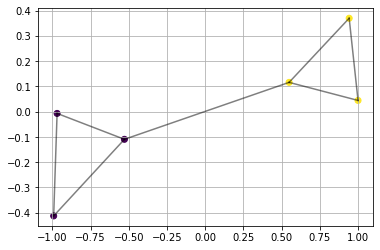

In [8]:
visualization.show_data(embedder.embeddings, graph=graph, labels=labels)

#### Kamada Kawai

In [9]:
embedder = embedding.KamadaKawaiEmbedder()
embedder.embed(builder.graph)

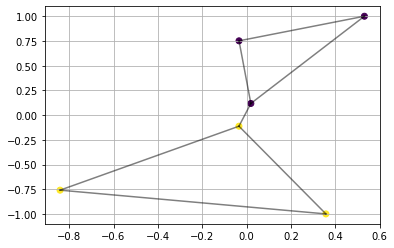

In [10]:
visualization.show_data(embedder.embeddings, graph=graph, labels=labels)

### With node features
We can add all the features from initial dataset as node features. Then we use GraphSAGE to learn embeddings.

In [13]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal, feature_fun=features.feature_coords)
builder.build(data)

#### GraphSAGE

In [14]:
embedder = embedding.GraphSAGEEmbedder()
embedder.embed(builder.graph)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/4
22/22 [==============================] - 3s 56ms/step - loss: 5.9435 - binary_accuracy: 0.4972
Epoch 2/4
22/22 [==============================] - 1s 62ms/step - loss: 5.4713 - binary_accuracy: 0.4972
Epoch 3/4
22/22 [==============================] - 1s 52ms/step - loss: 5.1964 - binary_accuracy: 0.5111
Epoch 4/4
1/1 [==============================] - 0s 260ms/step


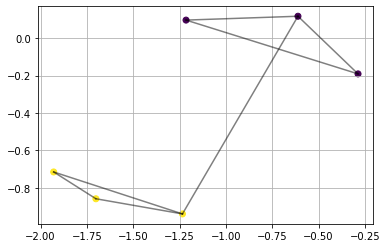

In [15]:
visualization.show_data(embedder.embeddings, graph=graph, labels=labels)

## Results on real datasets
### Dataset: Iris

For real datasets, we first remove duplicities, as we want to avoid nodes with distance 0.

In [16]:
iris = load_iris()
data = iris.data
labels = iris.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

#### Spring

In [17]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)

The whole dimensionality reduction pipeline is implemented as a reduce_dimension function in dim_reduction module

In [18]:
embedder = embedding.SpringEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

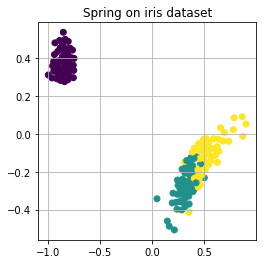

In [19]:
visualization.show_data(embeddings, labels=labels, title='Spring on iris dataset', square=True, dpi=500, outpath='iris_spring.png')

In [20]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9628061159751301
Continuity: 0.970546250475828


#### Kamada Kawai

In [21]:
embedder = embedding.KamadaKawaiEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder, compute_graph=False)

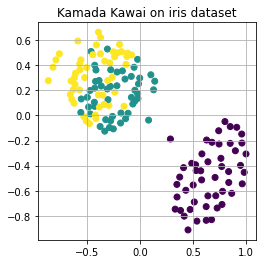

In [22]:
visualization.show_data(embeddings, labels=labels, title='Kamada Kawai on iris dataset', square=True, dpi=500, outpath='iris_kamada.png')

In [23]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9023521761197818
Continuity: 0.9154453749524172


#### GraphSAGE

In [29]:
builder = build.CheapestBuilder(weight_fun=weights.get_reciprocal_pow(5), feature_fun=features.feature_coords)
embedder = embedding.GraphSAGEEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/4
537/537 [==============================] - 46s 77ms/step - loss: 3.1653 - binary_accuracy: 0.6354
Epoch 2/4
537/537 [==============================] - 35s 65ms/step - loss: 3.0298 - binary_accuracy: 0.6231 1s - loss: 3.058
Epoch 3/4
537/537 [==============================] - 42s 79ms/step - loss: 3.6249 - binary_accuracy: 0.6265
Epoch 4/4
3/3 [==============================] - 0s 36ms/step


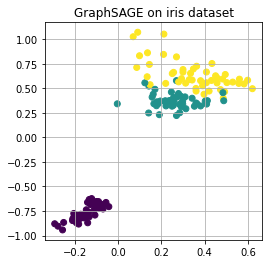

In [30]:
visualization.show_data(embeddings, labels=labels, title='GraphSAGE on iris dataset', square=True, dpi=500, outpath='iris_graphsage.png')

In [31]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9286892526329146
Continuity: 0.9593246415429514


#### Comparison: PCA

In [32]:
pca = PCA(n_components=2)
embeddings = pca.fit_transform(data)

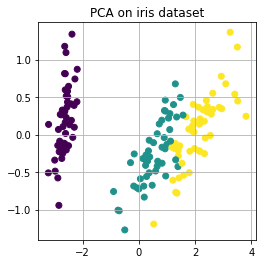

In [33]:
visualization.show_data(embeddings, labels=labels, title='PCA on iris dataset', square=True, dpi=500, outpath='iris_pca.png')

In [34]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9837980586220023
Continuity: 0.9937666539779216


#### Comparison: UMAP

In [35]:
umap_obj = umap.UMAP(n_components=2, random_state=42)
embeddings = umap_obj.fit_transform(data)

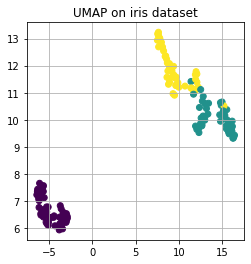

In [36]:
visualization.show_data(embeddings, labels=labels, title='UMAP on iris dataset', square=True, dpi=500, outpath='iris_umap.png')

In [37]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9844562872731887
Continuity: 0.9888576957238929


### Dataset: Digits

In [38]:
digits = load_digits()
data = digits.data
labels = digits.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

#### Spring

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)

In [40]:
embedder = embedding.SpringEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

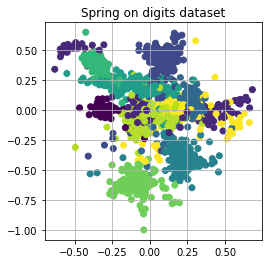

In [41]:
visualization.show_data(embeddings, labels=labels, title='Spring on digits dataset', square=True, dpi=500, outpath='digits_spring.png')

In [42]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9182117928108398
Continuity: 0.9783909930198703


#### Kamada Kawai

In [45]:
embedder = embedding.KamadaKawaiEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

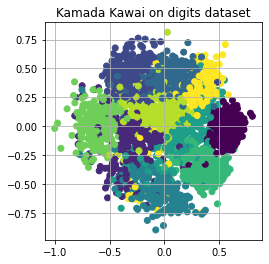

In [46]:
visualization.show_data(embeddings, labels=labels, title='Kamada Kawai on digits dataset', square=True, dpi=500, outpath='digits_kamada.png')

In [47]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.8727804494158341
Continuity: 0.9661153172993575


#### GraphSAGE

In [51]:
builder = build.CheapestBuilder(weight_fun=weights.get_reciprocal_pow(5), feature_fun=features.feature_coords)

In [52]:
embedder = embedding.GraphSAGEEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/4
6470/6470 [==============================] - 498s 76ms/step - loss: 4.8273 - binary_accuracy: 0.68155s - loss: 4.8320 - binary_accuracy: 0.681 - ETA: 5 - ETA: 1s - loss: 4.828
Epoch 2/4
6470/6470 [==============================] - 451s 70ms/step - loss: 4.7527 - binary_accuracy: 0.68835s - loss: - ETA: 2s - l - ETA: 0s - loss: 4.7525 - binary_accuracy: 
Epoch 3/4
6470/6470 [==============================] - 522s 81ms/step - loss: 5.0983 - binary_accuracy: 0.6658
Epoch 4/4
36/36 [==============================] - 2s 47ms/step


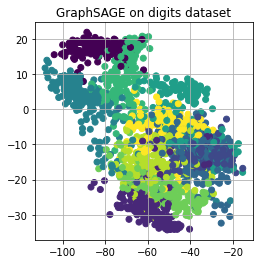

In [53]:
visualization.show_data(embeddings, labels=labels, title='GraphSAGE on digits dataset', square=True, dpi=500, outpath='digits_graphsage.png')

In [54]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.8462272357774155
Continuity: 0.9530870380278127


#### Comparison: PCA

In [55]:
pca = PCA(n_components=2)
embeddings = pca.fit_transform(data)

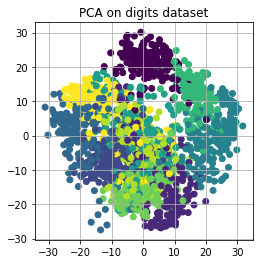

In [56]:
visualization.show_data(embeddings, labels=labels, title='PCA on digits dataset', square=True, dpi=500, outpath='digits_pca.png')

In [57]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.8591223824513817
Continuity: 0.964612339442502


#### Comparison: UMAP

In [58]:
umap_obj = umap.UMAP(n_components=2, random_state=42)
embeddings = umap_obj.fit_transform(data)

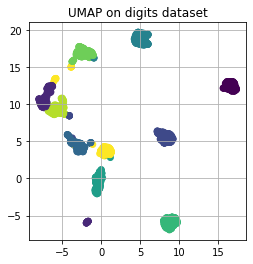

In [59]:
visualization.show_data(embeddings, labels=labels, title='UMAP on digits dataset', square=True, dpi=500, outpath='digits_umap.png')

In [60]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9913177638700527
Continuity: 0.992700518014375


### Dataset: Swiss roll

In [95]:
from sklearn.datasets import make_swiss_roll

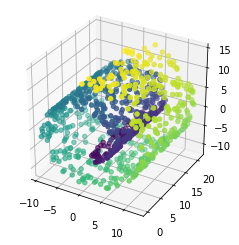

In [96]:
data, labels = make_swiss_roll(n_samples=1000, noise=0.0, random_state=0)
visualization.show_data(data, labels=labels, square=True, dpi=500, outpath='swissroll.png')

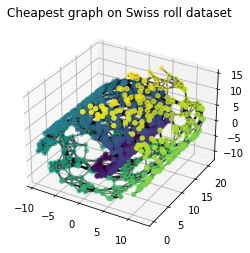

In [97]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal, feature_fun=features.feature_coords)
builder.build(data)
visualization.show_data(data, graph=builder.graph, labels=labels, title='Cheapest graph on Swiss roll dataset', dpi=500, outpath='swissroll_graph.png')

#### Spring

In [98]:
embedder = embedding.SpringEmbedder()
embedder.embed(builder.graph)
embeddings = embedder.embeddings

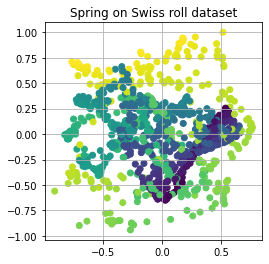

In [99]:
visualization.show_data(embeddings, labels=labels, square=True, title='Spring on Swiss roll dataset', dpi=500, outpath='swissroll_spring.png')

In [100]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.8805880402053614
Continuity: 0.993086406312321


#### Kamada Kawai

In [101]:
embedder = embedding.KamadaKawaiEmbedder()
embedder.embed(builder.graph)
embeddings = embedder.embeddings

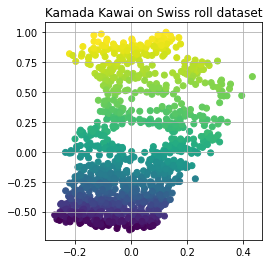

In [102]:
visualization.show_data(embeddings, labels=labels, square=True, title='Kamada Kawai on Swiss roll dataset', dpi=500, outpath='swissroll_kamada.png')

In [103]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9983891242702925
Continuity: 0.9981288774507976


#### GraphSAGE

In [70]:
embedder = embedding.GraphSAGEEmbedder(epochs=4, num_samples=[10, 5], layer_sizes=[20, 2])
embedder.embed(builder.graph)
embeddings = embedder.embeddings

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/4
3600/3600 [==============================] - 238s 65ms/step - loss: 4.0446 - binary_accuracy: 0.7281
Epoch 2/4
3600/3600 [==============================] - 257s 71ms/step - loss: 3.8970 - binary_accuracy: 0.7407
Epoch 3/4
3600/3600 [==============================] - 239s 66ms/step - loss: 4.3610 - binary_accuracy: 0.7059
Epoch 4/4
20/20 [==============================] - 1s 52ms/step


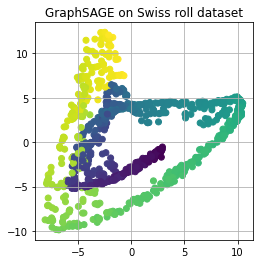

In [72]:
visualization.show_data(embeddings, labels=labels, square=True, title='GraphSAGE on Swiss roll dataset', dpi=500, outpath='swissroll_graphsage.png')

In [73]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9417850210062362
Continuity: 0.9916978072399355


#### Comparison: PCA

In [74]:
pca = PCA(n_components=2)
embeddings = pca.fit_transform(data)

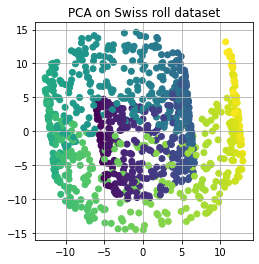

In [75]:
visualization.show_data(embeddings, labels=labels, square=True, title='PCA on Swiss roll dataset', dpi=500, outpath='swissroll_pca.png')

In [76]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9258147035924814
Continuity: 0.9974344939098212


#### Comparison: UMAP

In [77]:
umap_obj = umap.UMAP(n_components=2, random_state=42)
embeddings = umap_obj.fit_transform(data)

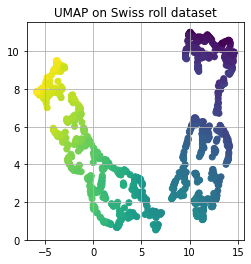

In [78]:
visualization.show_data(embeddings, labels=labels, square=True, title='UMAP on Swiss roll dataset', dpi=500, outpath='swissroll_umap.png')

In [79]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.999307296554695
Continuity: 0.9979039126404013


### Reduction to dimension 10
We show dimensionality reduction from dimension 64 to dimension 10. We use the Digits dataset.
We can not use Spring embedder, since it can only project to 2D. However, we can use Kamada Kawai and GraphSAGE.

In [106]:
digits = load_digits()
data = digits.data
labels = digits.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

#### Kamada Kawai

In [81]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)

In [82]:
embedder = embedding.KamadaKawaiEmbedder(embedding_dim=10)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

In [83]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9948767279242513
Continuity: 0.9936867775690237


#### GraphSAGE

In [84]:
builder = build.CheapestBuilder(weight_fun=weights.get_reciprocal_pow(5), feature_fun=features.feature_coords)

In [85]:
embedder = embedding.GraphSAGEEmbedder(embedding_dim=10)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/4
2303/6470 [=========>....................] - ETA: 5:02 - loss: 4.9907 - binary_accuracy: 0.6718

KeyboardInterrupt: 

In [ ]:
evaluation.print_evaluation(data, embeddings)

#### Comparison: PCA

In [107]:
pca = PCA(n_components=10)
embeddings = pca.fit_transform(data)

In [108]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9978977699253048
Continuity: 0.9989587351159


#### Comparison: UMAP

In [88]:
umap_obj = umap.UMAP(n_components=10, random_state=42)
embeddings = umap_obj.fit_transform(data)

In [89]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9961265568426423
Continuity: 0.9944006026220071


## Other experiments

### Spanning tree builder

We also tried using spanning tree as a graph instead of our CheapestBuilder graph. The best results were obtained using Kamada & Kawai embedder.

#### 2D

In [90]:
builder = build.SpanningTreeBuilder(weight_fun=weights.reciprocal)
embedder = embedding.KamadaKawaiEmbedder(embedding_dim=2)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

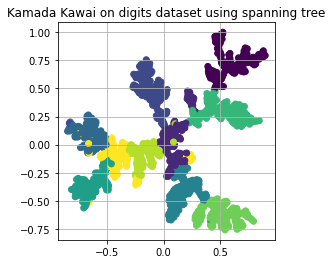

In [91]:
visualization.show_data(embeddings, labels=labels, square=True, title='Kamada Kawai on digits dataset using spanning tree', dpi=500, outpath='digits_kamada_spanning.png')

In [92]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9862757814800529
Continuity: 0.9851135670826542


#### 10D

In [104]:
embedder = embedding.KamadaKawaiEmbedder(embedding_dim=10)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

In [105]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9973321760834349
Continuity: 0.9969249208926954


### Data compression

We can ask, if our algorithm can actually compress data. As we saw, we have very good results for spanning tree graph and Kamada Kawai embedder when projecting to 10 dimensions. We can see, if our graph takes less memory than the dataset projected to 10d. If so, our graph is compressed version of 10d dataset while containing most of the essential information.

### Unsuccessful experiment: Node2vec

In [109]:
iris = load_iris()
data = iris.data
labels = iris.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

In [110]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)
embedder = embedding.Node2VecEmbedder(embedding_dim=2)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


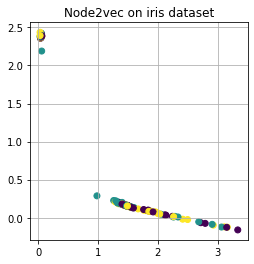

In [111]:
visualization.show_data(embeddings, labels=labels, square=True, title='Node2vec on iris dataset')

For some unknown reason, Node2vec projects on a line and a point in upper left corner. Also metrics are not good.  

In [112]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.5979412511102652
Continuity: 0.6094404263418348
